In [0]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch
from torch import nn
from torch import optim

import math

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm

In [2]:
!rm utils.py
!wget https://raw.githubusercontent.com/Intelligent-Systems-Phystech/model_selection/master/Grabovoy/practice/utils.py

rm: cannot remove 'utils.py': No such file or directory
--2019-10-22 16:14:09--  https://raw.githubusercontent.com/Intelligent-Systems-Phystech/model_selection/master/Grabovoy/practice/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2800 (2.7K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.73K  --.-KB/s    in 0s      

2019-10-22 16:14:09 (69.5 MB/s) - ‘utils.py’ saved [2800/2800]



In [0]:
from utils import gradient, jacobian, hessian

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Plot Setings

In [0]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = 24

# Experiment

In [0]:
m = 256
n = 50

w = np.random.randn(n)

X_train = np.random.randn(m, n)
Y_train = (X_train@w + 0.001*np.random.randn(m)).reshape([-1, 1])

X_test = np.random.randn(m, n)
Y_test = (X_test@w+ 0.001*np.random.randn(m)).reshape([-1, 1])

In [0]:
train_data = TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(Y_train).to(device))
test_data = TensorDataset(torch.Tensor(X_test).to(device), torch.Tensor(Y_test).to(device))

In [0]:
X_ts, Y_ts = test_data[:]

X_tr, Y_tr = train_data[:]

In [0]:
class Neural(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=3, output_dim=1, device='cpu'):
        """
        """
        super(Neural, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.device = device

        self.body = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.LeakyReLU(),
        )
        
        self.head = nn.Linear(self.hidden_dim, self.output_dim)
        
        list_of_w = []
        for w in self.parameters():
            list_of_w.append(w.data.view(-1))
        self.D = len(torch.cat(list_of_w).view(-1))
        self.S = torch.Tensor([0.5*1*(1+2*math.pi)]).mean().to(device)

        self.to(device)

        
    def predict(self, input):
        """
        Args:
            input: Tensor(batch_size x input_dim) --- the matrix of input data
            
        Returns:
            Tensor(batch_size x output_dim) --- the matrix of output data
        
        """
        out = input
        out = self.body(out)
        return self.head(out)
    
    def log_prior_w(self, w):
        """
        """
        sigma = 1.
        w = w.view(-1)
        return -0.5*(sigma**2)*torch.dot(w, w)-0.5*len(w)*math.log(2*math.pi)+len(w)*math.log(sigma)
      
    def log_priot_all(self):
        temp = 0
        for w in self.parameters():
            temp += self.log_prior_w(w)
        return temp
     
    def loglikelihood(self, batch_x, batch_y):
        """
        """
        beta = 1
        D = len(batch_y)
        return -0.5*beta*torch.sum((self.predict(batch_x) - batch_y)**2)- 0.5*D*math.log(2*math.pi) + 0.5*D*math.log(beta)
    
    def margin_log_likelihood(self, batch_x, batch_y):
        """
        """
        temp = self.log_priot_all() + self.loglikelihood(batch_x, batch_y)
        return temp/len(batch_y)
    
    def loss(self, batch_x, batch_y):
        out = self.predict(batch_x)
        return torch.mean((out - batch_y)**2)
    

100%|██████████| 1000/1000 [01:57<00:00,  8.60it/s]


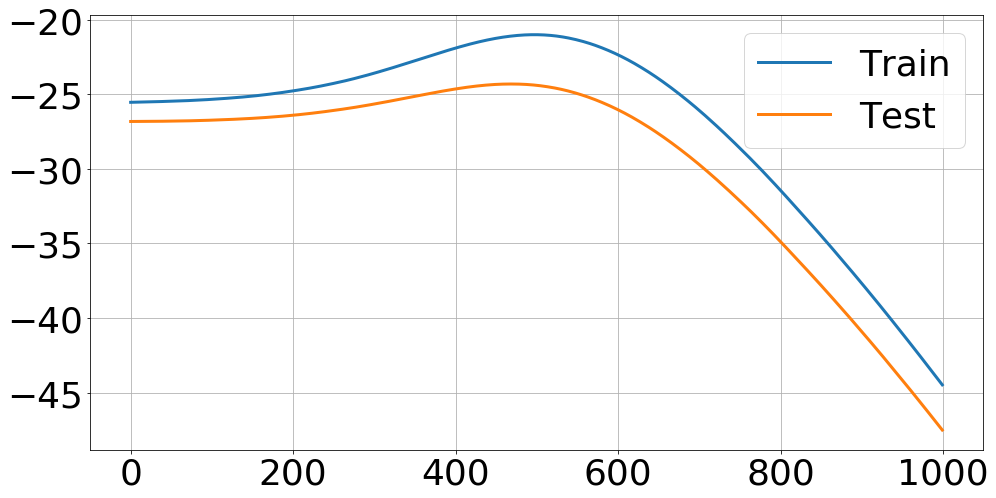

In [10]:
model = Neural(input_dim=n, output_dim=1, hidden_dim=1)
List_of_step = []

alpha = 0.0001

for ep in tqdm(range(1000)):
    generator = DataLoader(train_data, batch_size=64, shuffle=True)
    for batch_x, batch_y in generator:
        # подсчет энтропии
        model.zero_grad()
        margin_log_likelihood = -model.margin_log_likelihood(batch_x, batch_y)

        list_of_w = []
        for w in model.parameters():
            list_of_w.append(w)

        model.S = (model.S+torch.log(torch.det(torch.eye(model.D, device=device) - alpha*hessian(margin_log_likelihood, list_of_w)))).detach()

        # оптимизация параметров модели     
        model.zero_grad()

        optimazer = optim.SGD(model.parameters(), lr=alpha)

        loss = model.loss(batch_x, batch_y)
        loss.backward()

        optimazer.step()

    List_of_step.append((model.S.item(), model.log_priot_all().item(), len(Y_tr), model.loglikelihood(X_tr, Y_tr).item(), len(Y_ts), model.loglikelihood(X_ts, Y_ts).item()))
        
        
plt.plot([item[0]+(item[1]+item[3])/item[2] for item in List_of_step], label = 'Train')
plt.plot([item[0]+(item[1]+item[5])/item[4] for item in List_of_step], label = 'Test')

plt.grid()
plt.legend(loc='best')
plt.show()

100%|██████████| 1000/1000 [05:15<00:00,  3.27it/s]


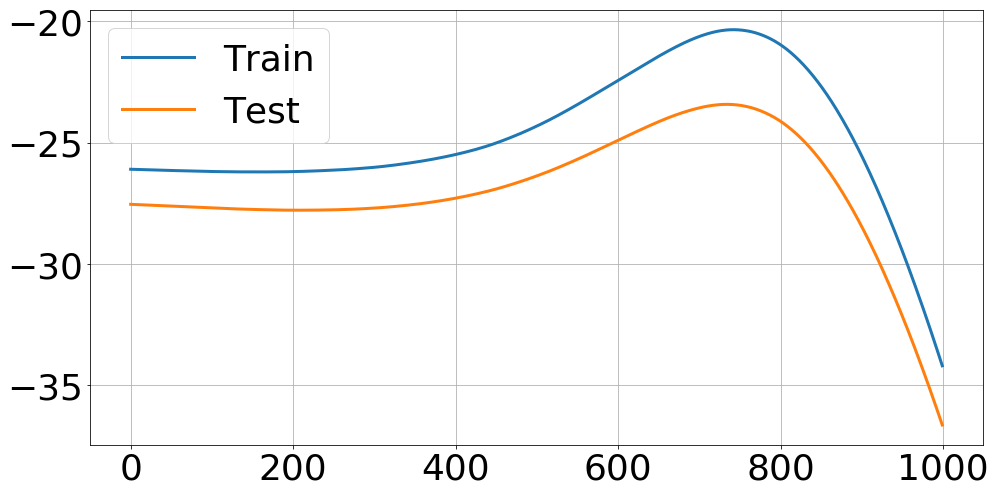

In [11]:
model = Neural(input_dim=n, output_dim=1, hidden_dim=3)
List_of_step = []

alpha = 0.0001

for ep in tqdm(range(1000)):
    generator = DataLoader(train_data, batch_size=64, shuffle=True)
    for batch_x, batch_y in generator:
        # подсчет энтропии
        model.zero_grad()
        margin_log_likelihood = -model.margin_log_likelihood(batch_x, batch_y)

        list_of_w = []
        for w in model.parameters():
            list_of_w.append(w)

        model.S = (model.S+torch.log(torch.det(torch.eye(model.D, device=device) - alpha*hessian(margin_log_likelihood, list_of_w)))).detach()

        # оптимизация параметров модели     
        model.zero_grad()

        optimazer = optim.SGD(model.parameters(), lr=alpha)

        loss = model.loss(batch_x, batch_y)
        loss.backward()

        optimazer.step()

    List_of_step.append((model.S.item(), model.log_priot_all().item(), len(Y_tr), model.loglikelihood(X_tr, Y_tr).item(), len(Y_ts), model.loglikelihood(X_ts, Y_ts).item()))
        
        
plt.plot([item[0]+(item[1]+item[3])/item[2] for item in List_of_step], label = 'Train')
plt.plot([item[0]+(item[1]+item[5])/item[4] for item in List_of_step], label = 'Test')

plt.grid()
plt.legend(loc='best')
plt.show()

100%|██████████| 1000/1000 [16:51<00:00,  1.00s/it]


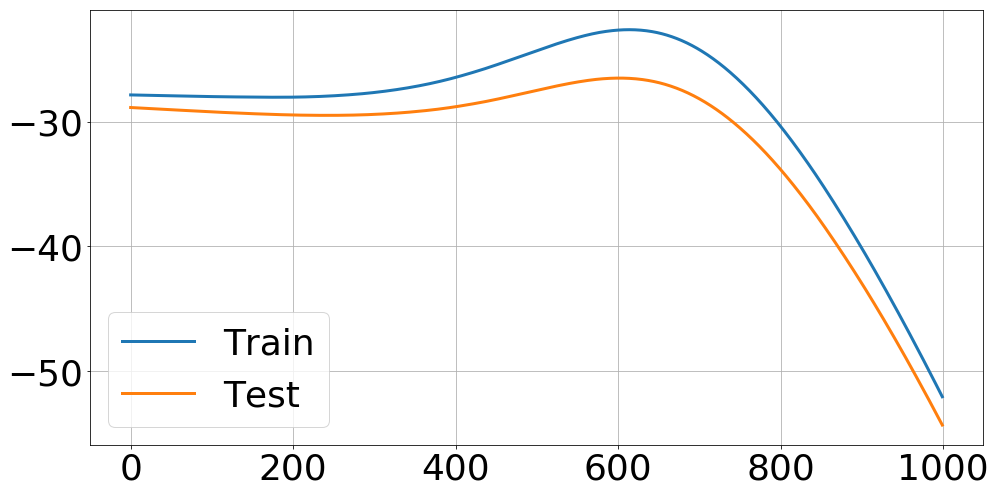

In [12]:
model = Neural(input_dim=n, output_dim=1, hidden_dim=10)
List_of_step = []

alpha = 0.0001

for ep in tqdm(range(1000)):
    generator = DataLoader(train_data, batch_size=64, shuffle=True)
    for batch_x, batch_y in generator:
        # подсчет энтропии
        model.zero_grad()
        margin_log_likelihood = -model.margin_log_likelihood(batch_x, batch_y)

        list_of_w = []
        for w in model.parameters():
            list_of_w.append(w)

        model.S = (model.S+torch.log(torch.det(torch.eye(model.D, device=device) - alpha*hessian(margin_log_likelihood, list_of_w)))).detach()

        # оптимизация параметров модели     
        model.zero_grad()

        optimazer = optim.SGD(model.parameters(), lr=alpha)

        loss = model.loss(batch_x, batch_y)
        loss.backward()

        optimazer.step()

    List_of_step.append((model.S.item(), model.log_priot_all().item(), len(Y_tr), model.loglikelihood(X_tr, Y_tr).item(), len(Y_ts), model.loglikelihood(X_ts, Y_ts).item()))
        
        
plt.plot([item[0]+(item[1]+item[3])/item[2] for item in List_of_step], label = 'Train')
plt.plot([item[0]+(item[1]+item[5])/item[4] for item in List_of_step], label = 'Test')

plt.grid()
plt.legend(loc='best')
plt.show()